In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.integrate import odeint

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Importing data

In [8]:
# Experimental conditions
conds = ['NL', '06hr','09hr','15hr','18hr', '21hr','24hr']
on_times = {'NL':0, '06hr':6,'09hr':9,'15hr':15,'18hr':18, '21hr':21,'24hr':24}

In [6]:
# Time vector
time = np.linspace(0,115/3,231)

In [ ]:
# Importing data
data = {}
for cond in conds:
    data[cond] = {}
    data[cond]['TF'] = np.genfromtxt('./data/TF_'+cond+'.csv', delimiter=',')
    data[cond]['bcat'] = np.genfromtxt('./data/bcat_'+cond+'.csv', delimiter=',')

# ODE Model

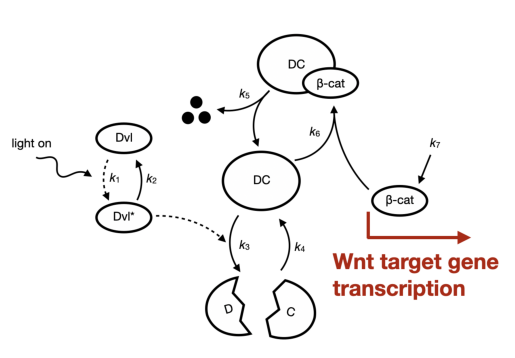

In [29]:
# Model schematic
img = plt.imread('./figures/Fig2A.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

In [5]:
### ODE MODEL ###
def bcat_model(y, t, params, Wnt_function, Wnt_params):
    n = 2
    dvltot, a1, a2, k1, k2, k3, k4, k5, DCtot, rmax, K = params
    dvl, dc, dc_bcat, bcat, tf = y
    dydt = [a1*Wnt_function(t,Wnt_params)*(dvltot-dvl) - a2*dvl, -k1*dvl*dc +k2*(DCtot-dc-dc_bcat) + k3*dc_bcat - k4*dc*bcat, -k3*dc_bcat + k4*dc*bcat, -k4*dc*bcat+k5, rmax*(bcat-1)**n/((bcat-1)**n + K**n)]#rmax*(bcat-1)**2] #
    return dydt

### STEADY STATE VALUES ###
def bcat_steady_state(params):
    # Calculate steady state values of the model
    dvltot, a1, a2, k1, k2, k3, k4, k5, DCtot, rmax, K = params
    dvl0 = 0
    dc_bcat0 = k5/k3
    dc0 = DCtot - k5/k3
    bcat0 = k5/(dc0*k4)
    tf0 = 1
    return [dvl0, dc0, dc_bcat0, bcat0, tf0]

### WNT SIMULATION FUNCTIONS ###
def Wnt_duty_freq(t, params):
    # Light on/off function returning 1 or 0 based on frequency and duty cycle.
    # params = [frequency, duty_cycle]
    frequency, duty_cycle = params
    period = 1.0 / frequency
    if (t % period) < duty_cycle * period:
        return 1
    else:
        return 0

def Wnt_on_time(t, ontime):
    # Light on/off function returning 1 or 0 based on on-time.
    if t <= ontime:
        return 1
    else:
        return 0

def Wnt_two_pulses(t, params):
    # Light on/off function returning 1 or 0 for two pulses.
    # params = [pulse_length, pause]
    pulse_length = params[0]
    pause = params[1]
    if (t <= pulse_length) or (pulse_length + pause <= t <= 2*pulse_length+pause):
        return 1
    else:
        return 0

In [15]:
### PARAMETERS ###

# b-cat
a1,a2,k2 = [10,10,3]
dvltot = 1
k5 = 0.42*60/91
k1 = 0.11*k2*(1+a2/a1) / dvltot 
k3 = k5*91/62.5 
k4 = 91*k5/82.4
DCtot = k5*(1/k4 + 1/k3)

# TopFlash
rmax = 6.5
K = 1

params = [dvltot, a1, a2, k1, k2, k3, k4, k5, DCtot, rmax, K]

# Initial conditions
y0 = bcat_steady_state(params)

## Exposure-time experiment

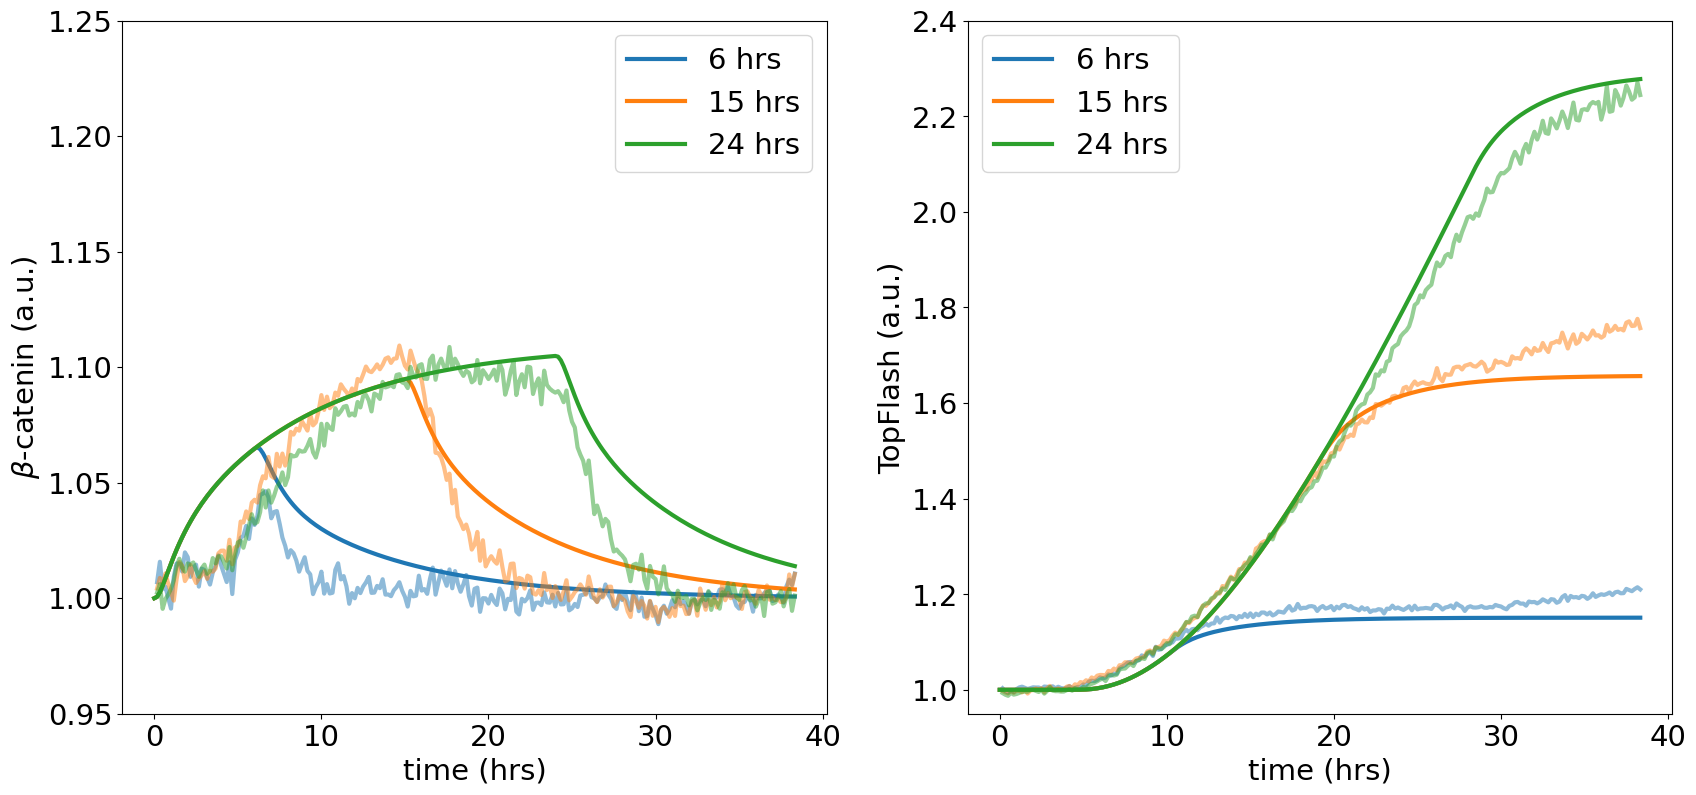

In [18]:
# Solving the ODE for experimental on-time conditions
sols = {}
for cond in ['NL','06hr','09hr', '15hr','18hr', '21hr', '24hr']:
    sols[cond] = odeint(bcat_model, y0, time, args=(params, Wnt_on_time, on_times[cond]))
    sols[cond][:, 4] = np.concatenate((np.ones(24), sols[cond][:, 4][:-24]))

# Plotting
labels = [r"$\beta$-cat", r"TopFlash"]
colors =  {'NL': 'tab:red', '06hr': 'tab:blue', '09hr': 'tab:cyan', '15hr':'tab:orange', '18hr':'tab:purple', '21hr':'tab:pink', '24hr':'tab:green'}

fig, axs = plt.subplots(1,2,figsize=(20,9)) #dpi=200)
for cond in ['06hr', '15hr','24hr']:
    for i in np.arange(len(labels)):
        if i == 0:
            axs[i].plot(time[1:], data[cond]['bcat'][1:], color = colors[cond], alpha = 0.5, linewidth=3)
        if i == 1:
            axs[i].plot(time[1:], data[cond]['TF'][1:], color = colors[cond], alpha = 0.5, linewidth=3)
        axs[i].plot(time, sols[cond][:, i+3], label=str(on_times[cond]) + ' hrs', linewidth=3, color=colors[cond])
        axs[i].set_xlabel('time (hrs)', fontsize=21)
        axs[i].legend(fontsize=21)
        axs[i].tick_params(labelsize=21)
    axs[0].set_ylabel(r"$\beta$-catenin (a.u.)", fontsize=21)
    axs[1].set_ylabel(r"TopFlash (a.u.)", fontsize=21)
    axs[0].set_ylim((0.95,1.25))
    axs[1].set_ylim((0.95,2.4))

plt.savefig('./figures/Fig2BC.pdf', bbox_inches='tight')

## Duty cycle and frequency scan

In [17]:
# Experimental duty cycle and frequency conditions
freqs = np.array([1/48, 1/24, 1/16, 1/12, 1/8, 1/6, 1/4, 1/3, 1/2, 1, 2, 4, 8])
duty_cycles = np.array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [19]:
# Experiment duration
T = 48

# Time vector
t = np.linspace(0, T, 10000)

# Output matrices
topflash_out = np.zeros(len(freqs)*len(duty_cycles))
bcat_out = np.zeros(len(freqs)*len(duty_cycles))

freq_out = np.zeros(0)
duty_cycle_out = np.zeros(0)
for i in np.arange(len(duty_cycles)):
    freq_out = np.append(freq_out, freqs)
for i in np.arange(len(freqs)):
    duty_cycle_out = np.append(duty_cycle_out, duty_cycles)
duty_cycle_out = np.sort(duty_cycle_out)

for i in np.arange(len(freq_out)):
    # Solve ODE
    sol = odeint(bcat_model, y0, t, args=(params, Wnt_duty_freq, [freq_out[i], duty_cycle_out[i]]), tcrit =t)
    topflash_out[i] = sol[-1, 4]
    bcat_out[i] = sol[-1,3]

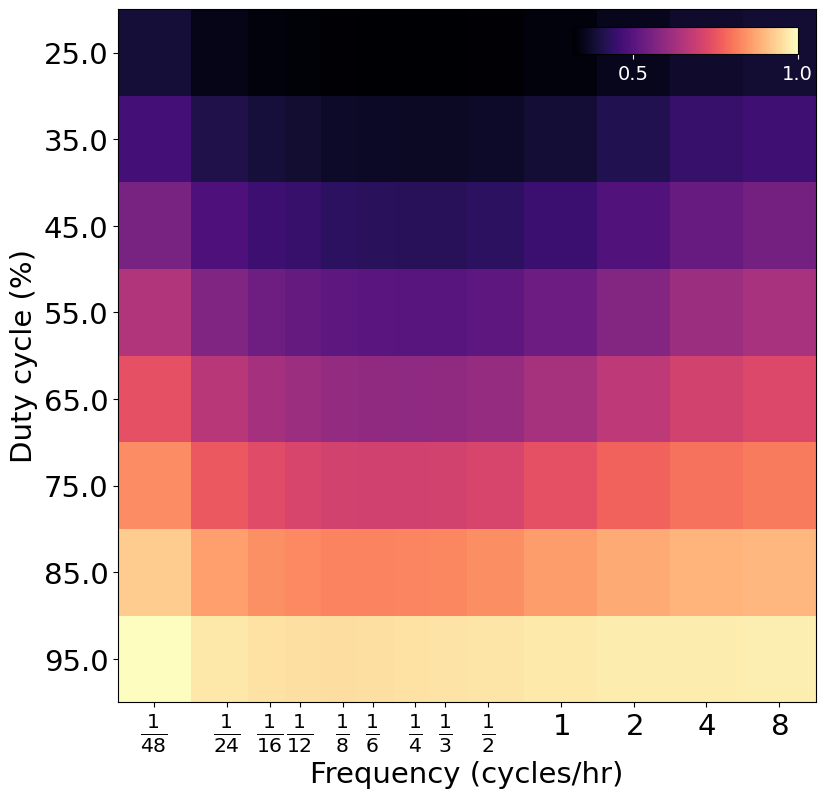

In [31]:
# Plotting TopFlash heatmap

x_values = np.log(freqs)  
y_values = duty_cycles  
color_values = topflash_out / np.max(topflash_out) 

X, Y = np.meshgrid(x_values, y_values)

fig, ax = plt.subplots(1, figsize=(9,9))
im = ax.pcolormesh(X, Y, color_values.reshape(len(duty_cycles),len(freqs)), cmap='magma')

ax.set_xlabel(r"Frequency (cycles/hr)", fontsize=21)
ax.set_ylabel(r"Duty cycle (%)", fontsize=21)
ax.set_xticks(np.log([1/48, 1/24,1/16,1/12,1/8,1/6,1/4,1/3,1/2,1,2,4,8]),[r'$\frac{1}{48}$', r'$\frac{1}{24}$', r'$\frac{1}{16}$', r'$\frac{1}{12}$', r'$\frac{1}{8}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$', r'$8$']); 
ax.set_yticks(duty_cycles, np.round(np.array(duty_cycles)*100,0)); 
ax.tick_params(labelsize=21)
ax.invert_yaxis()

cb = fig.add_axes([0.63, 0.83, 0.25, 0.03])
color_bar = plt.colorbar(im, cax = cb, orientation = 'horizontal', ticks = [0.5, 1])

color_bar.ax.xaxis.set_tick_params(color='white')
color_bar.ax.tick_params(axis='x', colors='white', labelsize=14)

plt.savefig('./figures/Fig2E.pdf', bbox_inches='tight')

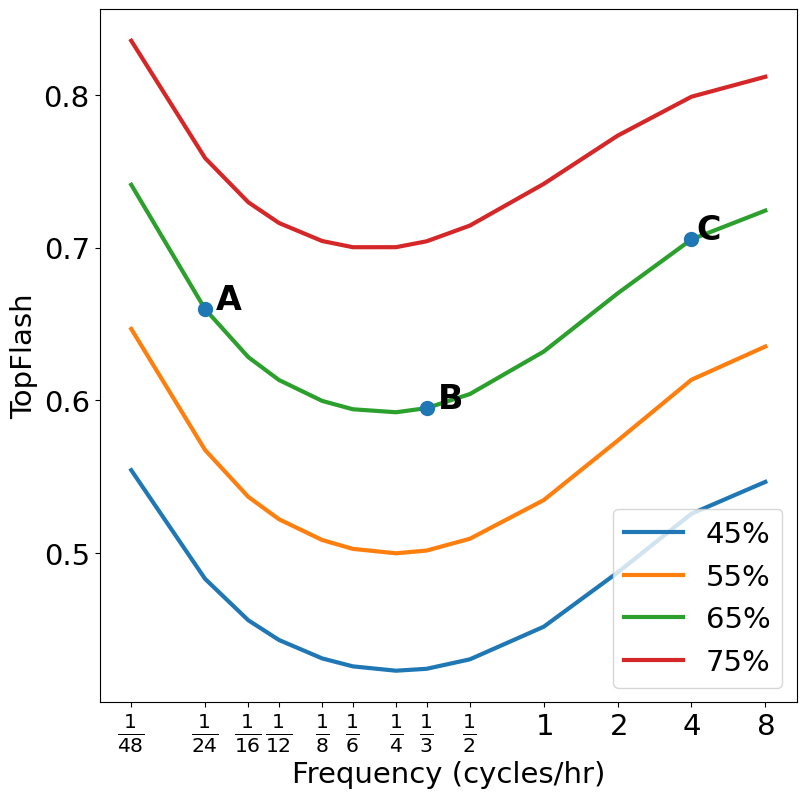

In [24]:
# Plotting constant duty cycle traces

fig, ax = plt.subplots(1, figsize=(9,9))

for i in [2,3,4,5]:
    ax.plot(np.log(freqs), topflash_out[duty_cycle_out == duty_cycles[i]] / np.max(topflash_out), label = str(int(duty_cycles[i]*100))+'%', linewidth=3)
ax.legend(loc='lower right', fontsize=21)
ax.set_xlabel(r"Frequency (cycles/hr)", fontsize=21)
ax.set_ylabel(r"TopFlash", fontsize=21)
ax.set_xticks(np.log(freqs),[r'$\frac{1}{48}$', r'$\frac{1}{24}$', r'$\frac{1}{16}$', r'$\frac{1}{12}$', r'$\frac{1}{8}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$', r'$8$']); 
ax.tick_params(labelsize=21)


# Labelling three points
labels = [r'$\ \mathbf{A}$', r'$\ \mathbf{B}$', r'$\, \mathbf{C}$']
labelx = [np.log(1/24), np.log(1/3), np.log(4)]
labely = [topflash_out[duty_cycle_out == 0.65][1], topflash_out[duty_cycle_out == 0.65][7], topflash_out[duty_cycle_out == 0.65][-2]] / np.max(topflash_out)
ax.scatter(labelx,labely, zorder=3, marker = 'o', s = 100)

for i, label in enumerate(labels):
    ax.annotate(label, (labelx[i], labely[i]), fontsize=24)

plt.savefig('./figures/Fig2F.pdf', bbox_inches='tight')

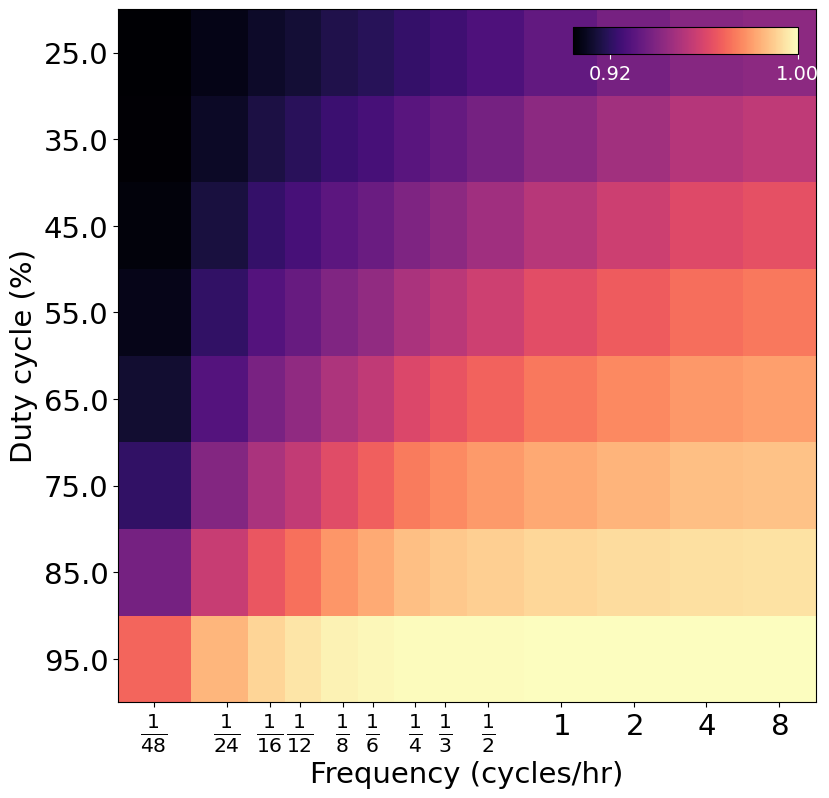

In [32]:
# Plotting b-cat heatmap

x_values = np.log(freqs)
y_values = duty_cycles
color_values = bcat_out / np.max(bcat_out)

X, Y = np.meshgrid(x_values, y_values)

fig, ax = plt.subplots(1, figsize=(9,9))
im = ax.pcolormesh(X, Y, color_values.reshape(len(duty_cycles),len(freqs)), cmap='magma') 

ax.set_xlabel(r"Frequency (cycles/hr)", fontsize=21)
ax.set_ylabel(r"Duty cycle (%)", fontsize=21)
ax.set_xticks(np.log([1/48, 1/24,1/16,1/12,1/8,1/6,1/4,1/3,1/2,1,2,4,8]),[r'$\frac{1}{48}$', r'$\frac{1}{24}$', r'$\frac{1}{16}$', r'$\frac{1}{12}$', r'$\frac{1}{8}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$', r'$8$']); 
ax.set_yticks(duty_cycles, np.round(np.array(duty_cycles)*100,0)); 
ax.tick_params(labelsize=21)
ax.invert_yaxis()

cb = fig.add_axes([0.63, 0.83, 0.25, 0.03])
color_bar = plt.colorbar(im, cax = cb, orientation = 'horizontal', ticks = [0.92,1])

# Change color bar tick labels to white
color_bar.ax.xaxis.set_tick_params(color='white')
color_bar.ax.tick_params(axis='x', colors='white', labelsize=14)

fig.savefig('./figures/SuppFig2A.pdf')